## Project: Analysing Currency Trends (based on Bitcoin, USD, GBP in relation Euro).

***

### 1. Data Collection

***

Importing libraries.

In [1]:
import yfinance as yf
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from matplotlib import font_manager
import warnings
import logging
from fuctions import *
#from fuctions import flattenColumns

I've noticed that the Yahoo Finance API has many limitations. The API returns error messages that provide information on correctly fetching specific data. I selected the most suitable data for my project based on a particular range of time and granularity. The selection of data was influenced by availability and demand. Attempts to retrieve large volumes of data across different periods to multiply the data were unsuccessful. The API limits strictly define that data must be from today's date and are dependent on specific API constraints. As a result, I decided to break the data into smaller chunks to prevent losing any data.

I added a function to log any warnings that may occur during the execution of the script. This function will log the warning to a file. This will help me to debug the script if any warnings occur.

In [2]:
warnings.showwarning = logWarning

Here is a few examples entry from the log file to help understand the syntax of the Yahoo Finance API interface:

```log File
YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=2y) (Yahoo error = "Invalid input - interval=50m is not supported. Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]")')

YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=2y) (Yahoo error = "15m data not available for startTime=1671481488 and endTime=1734553488. The requested range must be within the last 60 days.")')
```

***

Downloading exchange rate USD to EUR represented by USDEUR=X and GBP to EUR represented by GBPEUR=X.

In [12]:
# Download USD/EUR and GBP/EUR exchange rates
eur2yraw = yf.download(['USDEUR=X', 'GBPEUR=X'], period='2y', interval='60m', group_by='ticker')
eur5yraw = yf.download(['USDEUR=X', 'GBPEUR=X'], period='5y', interval='1d', group_by='ticker')
eur5draw = yf.download(['USDEUR=X', 'GBPEUR=X'], period='5d', interval='5m', group_by='ticker')

eur5draw.head(2)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


Ticker                    GBPEUR=X                                             \
Price                         Open     High     Low    Close Adj Close Volume   
Datetime                                                                        
2024-12-12 00:00:00+00:00  1.21491  1.21508  1.2146  1.21503   1.21503      0   
2024-12-12 00:05:00+00:00  1.21503  1.21509  1.2147  1.21496   1.21496      0   

Ticker                    USDEUR=X                                           
Price                         Open    High     Low   Close Adj Close Volume  
Datetime                                                                     
2024-12-12 00:00:00+00:00   0.9516  0.9516  0.9514  0.9514    0.9514      0  
2024-12-12 00:05:00+00:00   0.9514  0.9514  0.9514  0.9514    0.9514      0

Downloading exchange rate BTC to EUR represented by BTC-EUR.

In [11]:
# Download BTC-EUR data
btc2yraw = yf.download('BTC-EUR', period='2y', interval='60m')
btc5yraw = yf.download('BTC-EUR', period='5y', interval='1d')
btc5draw = yf.download('BTC-EUR', period='5d', interval='5m')

# For debugging purposes
btc2yraw.head(2)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR
Datetime,,,,,,
2022-12-18 22:00:00,15839.503906,15839.503906,15869.68750,15824.971680,15832.344727,0
2022-12-18 23:00:00,15842.189453,15842.189453,15876.90332,15839.095703,15839.095703,0


I'm going to save the data to separate CSV files, but before I do so, I will format them a bit.

First, I changed the sequence of columns to match with other Data Frames.

In [5]:
# Define the list of DataFrames
dataframes = [btc2yraw, btc5yraw, btc5draw]

# Define the desired order for the columns
newOrder = [
    ('Open', 'BTC-EUR'), 
    ('High', 'BTC-EUR'), 
    ('Low', 'BTC-EUR'),
    ('Close', 'BTC-EUR'), 
    ('Adj Close', 'BTC-EUR'), 
    ('Volume', 'BTC-EUR')
]

# Reorder the columns for each DataFrame
formatedDataFrames = []

for df in dataframes:
    # Reorder the columns using the new_order
    formatedDf = df[newOrder]
    formatedDataFrames.append(formatedDf)

btc2yraw, btc5yraw, btc5draw = formatedDataFrames
# For degurging purposes
btc5yraw.head()


Price,Open,High,Low,Close,Adj Close,Volume
Ticker,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR
Date,,,,,,
2019-12-18,5961.257324,6590.208496,5884.808105,6546.539062,6546.539062,28641568535
2019-12-19,6547.248535,6609.172363,6325.949219,6475.342773,6475.342773,23288187561
2019-12-20,6480.550293,6552.125488,6399.549316,6516.822754,6516.822754,20432789823
2019-12-21,6518.426758,6520.803711,6421.058105,6491.854492,6491.854492,17434503033
2019-12-22,6491.881348,6785.528320,6470.206543,6779.712402,6779.712402,20880470519


The next step is to flatten multi-index columns into single-level columns and rename 'Date' to 'Datetime' to match the other datasets.

In [ ]:
## List of DataFrames for 2 years, 5 years, and 5 days data
all2y = [eur2yraw, btc2yraw]
all5y = [eur5yraw, btc5yraw]
all5d = [eur5draw, btc5draw]

# Reset index for all DataFrames
for df_list in [all2y, all5y, all5d]:
    for df in df_list:
        df.reset_index(inplace=True)  # Resets the index for each DataFrame

# Apply flatten_columns function to each DataFrame in all lists
for df_list in [all2y, all5y, all5d]:
    for df in df_list:
        flattenColumns(df)
        
# Setting index for all DataFrames
for df_list in [all2y, all5y, all5d]:
    for df in df_list:
        df.set_index('Datetime', inplace=True)

# For degurging purposes
btc2yraw.head()


,Open_BTC-EUR,High_BTC-EUR,Low_BTC-EUR,Close_BTC-EUR,Adj Close_BTC-EUR,Volume_BTC-EUR
Datetime,,,,,,
2022-12-18 22:00:00,15832.344727,15869.687500,15824.971680,15839.503906,15839.503906,0
2022-12-18 23:00:00,15839.095703,15876.903320,15839.095703,15842.189453,15842.189453,0
2022-12-19 00:00:00,15832.535156,15862.791992,15812.431641,15839.987305,15839.987305,160080896
2022-12-19 01:00:00,15838.237305,15857.387695,15820.251953,15832.684570,15832.684570,436032512
2022-12-19 02:00:00,15829.939453,15830.400391,15782.148438,15786.166016,15786.166016,238223360


In [9]:
# Define the new order and column name mapping
#newOrder = ['BTC-EUR_Open', 'BTC-EUR_High', 'BTC-EUR_Low', 'BTC-EUR_Close', 'BTC-EUR_Adj Close', 'BTC-EUR_Volume']
rename_dict = {
    'Open_BTC-EUR': 'BTC-EUR_Open',
    'High_BTC-EUR': 'BTC-EUR_High',
    'Low_BTC-EUR': 'BTC-EUR_Low',
    'Close_BTC-EUR': 'BTC-EUR_Close',
    'Adj Close_BTC-EUR': 'BTC-EUR_Adj Close',
    'Volume_BTC-EUR': 'BTC-EUR_Volume'
}

# List of DataFrames to process
dataframes = [btc2yraw, btc5yraw, btc5draw]

# Rename columns and reorder the columns for each DataFrame
for df in dataframes:
    # Rename columns to match newOrder
    df.rename(columns=rename_dict, inplace=True)

# For degurging purposes
btc2yraw.head(3)


,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close,BTC-EUR_Adj Close,BTC-EUR_Volume
Datetime,,,,,,
2022-12-18 22:00:00,15832.344727,15869.687500,15824.971680,15839.503906,15839.503906,0
2022-12-18 23:00:00,15839.095703,15876.903320,15839.095703,15842.189453,15842.189453,0
2022-12-19 00:00:00,15832.535156,15862.791992,15812.431641,15839.987305,15839.987305,160080896


In [10]:
# Save the data to CSV files
eurToSave = [eur2yraw, eur5yraw, eur5draw]
filenames = ['eur2yraw.csv', 'eur5yraw.csv', 'eur5draw.csv']
for i in range(3):
    eurToSave[i].to_csv(f'data/csv/raw/{filenames[i]}')
print('Data saved to CSV files')

Data saved to CSV files


In [ ]:
# Save the data to CSV files
usdToSave = [usd2y, usd5y, usd5d]
filenames = ['usd2y.csv', 'usd5y.csv', 'usd5d.csv']
for i in range(3):
    usdToSave[i].to_csv(f'data/csv/{filenames[i]}')
print('Data saved to CSV files')


Data saved to CSV files


[*********************100%***********************]  1 of 2 completed

#### Data related to the Great British Pound (often referred to simply as the British Pounds) currency (GBP represent by symbol **£**).

Raw data are taken from Yahoo Finance.

In [ ]:
# Download 2 years of hourly data for GBPUSD and EURUSD currency pairs
gbp2y = yf.download(['GBPUSD=X', 'GBPEUR=X'], period='2y', interval='60m', group_by='ticker')
# Download 5 years of daily data for GBPUSD and EURUSD currency pairs
gbp5y = yf.download(['GBPUSD=X', 'GBPEUR=X'], period='5y', interval='1d', group_by='ticker')
# Download 5 days of 5 minute data for GBPUSD and EURUSD currency pairs
gbp5d = yf.download(['GBPUSD=X', 'GBPEUR=X'], period='5d', interval='5m', group_by='ticker')


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


Saving the data to CSV files.

In [ ]:
# Save the data to CSV files
gbpToSave = [gbp2y, gbp5y, gbp5d]
filenames = ['gbp2y.csv', 'gbp5y.csv', 'gbp5d.csv']
for i in range(3):
    gbpToSave[i].to_csv(f'data/csv/{filenames[i]}')
print('Data saved to CSV files')

Data saved to CSV files


#### Data related to official currency of the Eurozone knows as Euro currency (EUR: represent by **€**). 

Raw data are taken from Yahoo Finance.

In [ ]:
# Download 2 years of hourly data for EURUSD and EURGBP currency pairs
eur2y = yf.download(['EURUSD=X', 'EURGBP=X'], period='2y', interval='60m', group_by='ticker')
# Download 5 years of daily data for EURUSD and EURGBP currency pairs
eur5y = yf.download(['EURUSD=X', 'EURGBP=X'], period='5y', interval='1d', group_by='ticker')
# Download 5 days of 5 minute data for EURUSD and EURGBP currency pairs
eur5d = yf.download(['EURUSD=X', 'EURGBP=X'], period='5d', interval='5m', group_by='ticker')


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


Saving the data to CSV files.

In [ ]:
# Save the data to CSV files
eurToSave = [eur2y, eur5y, eur5d]
filenames = ['eur2y.csv', 'eur5y.csv', 'eur5d.csv']
for i in range(3):
    eurToSave[i].to_csv(f'data/csv/{filenames[i]}')
print('Data saved to CSV files')


Data saved to CSV files


#### Data related to the Bitcoin cryptocurrency (BTC represented by symbol **₿**)

Raw data are taken from Yahoo Finance.

In [ ]:
# Download 2 years of hourly data for BTCUSD, BTCGBP and BTCEUR currency pairs
btc2y = yf.download(['BTC-USD', 'BTC-GBP', 'BTC-EUR'], period='2y', interval='60m', group_by='ticker')
# Download 5 years of daily data for BTCUSD, BTCGBP and BTCEUR currency pairs
btc5y = yf.download(['BTC-USD', 'BTC-GBP', 'BTC-EUR'], period='5y', interval='1d', group_by='ticker')
# Download 5 days of 5 minute data for BTCUSD, BTCGBP and BTCEUR currency pairs
btc5d = yf.download(['BTC-USD', 'BTC-GBP', 'BTC-EUR'], period='5d', interval='5m', group_by='ticker')


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed


Saving the data to CSV files.

In [ ]:
# Save the data to CSV files
btcToSave = [btc2y, btc5y, btc5d]
filenames = ['btc2y.csv', 'btc5y.csv', 'btc5d.csv']
for i in range(3):
    btcToSave[i].to_csv(f'data/csv/{filenames[i]}')
print('Data saved to CSV files')


Data saved to CSV files


***

#### Preparing data to transfer to the Database.

Database Setup:

I will create an SQLite database named currency.db and set up individual tables for each currency pair and corresponding datasets. I will then insert the data from the CSV files into the tables. To ensure compatibility with the database structure, I need to flatten the multi-index columns in the data frames before inserting them into the database.

Reason for Downloading Separately:

When I attempted to download all the datasets at once, I noticed that some data was consistently missing or lost, even though the requested datasets were the same. This issue likely stemmed from limited access to Yahoo Finance's API, which can result in data loss when simultaneously querying large amounts of data.
By downloading the data separately, I can mitigate this problem and ensure I collect the better quality dataset for each currency pair without risking data corruption or loss due to API limitations.

Visual inspection of the data shows that the data is downloaded correctly. I noticed that the date format is different in 5 years of daily data than in 2 years of hourly data and 5 days of 5-minute data. I converted the date format to the same like in 2 years of hourly data and 5 days of 5-minute data.

Flattening the dataframes.

In [ ]:
# List of DataFrames for 2 years, 5 years, and 5 days data
all2y = [usd2y, gbp2y, eur2y, btc2y]
all5y = [usd5y, gbp5y, eur5y, btc5y]
all5d = [usd5d, gbp5d, eur5d, btc5d]

# Reset index for all DataFrames
for df_list in [all2y, all5y, all5d]:
    for df in df_list:
        df.reset_index(inplace=True)  # Resets the index for each DataFrame

# Function to flatten multi-index columns into single-level columns
def flatten_columns(df):
    # Rename 'Date' to 'Datetime' for all DataFrames in all5y
    if 'Date' in df.columns:
        df.rename(columns={'Date': 'Datetime'}, inplace=True)
    
    # Flatten multi-index columns to single level
    df.columns = ['Datetime' if isinstance(col, tuple) and col[0] == 'Datetime' 
                  else '_'.join(col).strip() for col in df.columns]

# Apply flatten_columns function to each DataFrame in all lists
for df_list in [all2y, all5y, all5d]:
    for df in df_list:
        flatten_columns(df)
        
# Setting index for all DataFrames
for df_list in [all2y, all5y, all5d]:
    for df in df_list:
        df.set_index('Datetime', inplace=True)
btc5d.head()


,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close,BTC-USD_Adj Close,BTC-USD_Volume,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close,BTC-EUR_Adj Close,BTC-EUR_Volume,BTC-GBP_Open,BTC-GBP_High,BTC-GBP_Low,BTC-GBP_Close,BTC-GBP_Adj Close,BTC-GBP_Volume
Datetime,,,,,,,,,,,,,,,,,,
2024-12-14 00:00:00+00:00,101434.617188,101447.039062,101434.617188,101444.703125,101444.703125,0,96552.671875,96564.492188,96552.671875,96562.273438,96562.273438,0,80369.687500,80385.921875,80369.687500,80384.070312,80384.070312,0
2024-12-14 00:05:00+00:00,101434.078125,101434.078125,101384.335938,101385.640625,101385.640625,11493376,96552.156250,96552.156250,96504.812500,96506.046875,96506.046875,10944512,80375.656250,80375.656250,80336.242188,80337.265625,80337.265625,9109504
2024-12-14 00:10:00+00:00,101374.179688,101374.179688,101354.257812,101354.257812,101354.257812,0,96506.046875,96506.046875,96476.179688,96476.179688,96476.179688,0,80337.265625,80337.265625,80312.406250,80312.406250,80312.406250,0
2024-12-14 00:15:00+00:00,101344.023438,101347.257812,101338.210938,101338.210938,101338.210938,0,96466.437500,96469.515625,96460.898438,96460.898438,96460.898438,0,80304.296875,80306.851562,80299.687500,80299.687500,80299.687500,0
2024-12-14 00:20:00+00:00,101384.203125,101489.398438,101384.203125,101489.398438,101489.398438,0,96504.679688,96604.812500,96504.679688,96604.812500,96604.812500,0,80336.132812,80419.492188,80336.132812,80419.492188,80419.492188,0


Transfer CSVfiles to the SQLite Database.

In [ ]:

# Connect to SQLite database (creates file if it doesn't exist)
conn = sqlite3.connect('data/db/currencies.db')

# List of DataFrames and their corresponding table names
dataframes = [(usd2y, 'usd2y'), (usd5y, 'usd5y'), (usd5d, 'usd5d'), 
              (gbp2y, 'gbp2y'), (gbp5y, 'gbp5y'), (gbp5d, 'gbp5d'), 
              (eur2y, 'eur2y'), (eur5y, 'eur5y'), (eur5d, 'eur5d'), 
              (btc2y, 'btc2y'), (btc5y, 'btc5y'), (btc5d, 'btc5d')]
# Loop to write each DataFrame to the SQLite database
for df, table_name in dataframes:
    df.to_sql(table_name, conn, if_exists='replace', index=True)
    
# Close the connection to SQLite
conn.close()

print("Data successfully written to SQLite database!")


Data successfully written to SQLite database!


Checking what tables contain the Database.

In [69]:
# Connect to the SQLite database
conn = sqlite3.connect('data/db/currencies.db')
cursor = conn.cursor()

# Query to list tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Print the tables
print("Tables in the database:")
for table in tables:
    print(table[0])

# Close the connection
conn.close()

Tables in the database:
usd2y
usd5y
usd5d
gbp2y
gbp5y
gbp5d
eur2y
eur5y
eur5d
btc2y
btc5y
btc5d


Testing  query to the Database.

In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect('data/db/currencies.db')

# Read data from the table into a pandas DataFrame
query = "SELECT * FROM gbp5y LIMIT 5;"  # Adjust for your table name
df = pd.read_sql(query, conn)
df.set_index('Datetime', inplace=True)

# Display the DataFrame

df

,GBPEUR=X_Open,GBPEUR=X_High,GBPEUR=X_Low,GBPEUR=X_Close,GBPEUR=X_Adj Close,GBPEUR=X_Volume,GBPUSD=X_Open,GBPUSD=X_High,GBPUSD=X_Low,GBPUSD=X_Close,GBPUSD=X_Adj Close,GBPUSD=X_Volume
Datetime,,,,,,,,,,,,
2019-12-18 00:00:00,1.17650,1.17847,1.17406,1.17659,1.17659,0,1.312215,1.312560,1.306233,1.312215,1.312215,0
2019-12-19 00:00:00,1.17699,1.17925,1.16898,1.17670,1.17670,0,1.308472,1.312956,1.299663,1.308729,1.308729,0
2019-12-20 00:00:00,1.17007,1.17938,1.16950,1.17000,1.17000,0,1.301643,1.307839,1.300830,1.301744,1.301744,0
2019-12-23 00:00:00,1.17367,1.17554,1.16416,1.17366,1.17366,0,1.300525,1.303254,1.290706,1.300542,1.300542,0
2019-12-24 00:00:00,1.16677,1.17019,1.16560,1.16650,1.16650,0,1.294448,1.296950,1.292307,1.294498,1.294498,0


Understanding collected data is kind of important. We can identify columns called:
* Open: Price at the start of the trading period.
* High: Highest price during the trading period.
* Low: Lowest price during the trading period.
* Close: Price at the end of the trading period.
* Adj Close: Close price adjusted for events like splits or dividends (not relevant in this case).
* Volume: Total amount of the asset traded during the period.

Display the first 3 row are commented out and was use only to check Data Frame and discover column names.

***

### 2. Data Cleaning

I chose to analyse OHLC data (Open, High, Low, Close) because it provides a comprehensive view of price movements, which is essential for identifying market trends and making informed trading decisions.

I will omit other data, such as volume or adjusted close, as they are less relevant for understanding price action and trend analysis. After examining the data, it is clear that the Adj Close column contains the same values as the Close column, and the Volume column is empty.

Formatting Data Frames for easier manipulation 

In [14]:
# Columns to drop (targeting columns that have '_Adj Close' or '_Volume' suffixes)
columnsToDrop = ['_Adj Close', '_Volume']

# List of DataFrames for each asset
dfColumnsDroppedList = [usd2y, gbp2y, eur2y, btc2y, usd5y, gbp5y, eur5y, btc5y, usd5d, gbp5d, eur5d, btc5d]

# Iterate over each DataFrame and drop columns that contain '_Adj Close' or '_Volume'
for df in dfColumnsDroppedList:
    df.drop([col for col in df.columns if any(drop in col for drop in columnsToDrop)], axis=1, inplace=True)

# Verify the result (Optional)
usd2y.head(3)


,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,USDGBP=X_Open,USDGBP=X_High,USDGBP=X_Low,USDGBP=X_Close
Datetime,,,,,,,,
2022-12-19 00:00:00,0.9444,0.9447,0.9431,0.9433,0.82224,0.82268,0.82102,0.82106
2022-12-19 01:00:00,0.9431,0.9434,0.9426,0.9426,0.82111,0.82135,0.81983,0.81987
2022-12-19 02:00:00,0.9424,0.9429,0.9419,0.9424,0.82022,0.82082,0.81959,0.82081


In [15]:
# Merge the DataFrames using 'Datetime' column and add suffixes
allFiatCurrencies2y = usd2y.merge(eur2y, how='outer', on='Datetime', suffixes=('_USD', '_EUR')).merge(gbp2y, how='outer', on='Datetime', suffixes=('_EUR', '_GBP'))
allFiatCurrencies5d = usd5d.merge(eur5d, how='outer', on='Datetime', suffixes=('_USD', '_EUR')).merge(gbp5d, how='outer', on='Datetime', suffixes=('_EUR', '_GBP'))
allFiatCurrencies5y = usd5y.merge(eur5y, how='outer', on='Datetime', suffixes=('_USD', '_EUR')).merge(gbp5y, how='outer', on='Datetime', suffixes=('_EUR', '_GBP'))
allFiatCurrencies2y.head(3)

,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,USDGBP=X_Open,USDGBP=X_High,USDGBP=X_Low,USDGBP=X_Close,EURUSD=X_Open,EURUSD=X_High,...,EURGBP=X_Low,EURGBP=X_Close,GBPUSD=X_Open,GBPUSD=X_High,GBPUSD=X_Low,GBPUSD=X_Close,GBPEUR=X_Open,GBPEUR=X_High,GBPEUR=X_Low,GBPEUR=X_Close
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-19 00:00:00,0.9444,0.9447,0.9431,0.9433,0.82224,0.82268,0.82102,0.82106,1.058873,1.060333,...,0.8699,0.87027,1.216190,1.217997,1.215539,1.217938,1.14867,1.14904,1.1477,1.14894
2022-12-19 01:00:00,0.9431,0.9434,0.9426,0.9426,0.82111,0.82135,0.81983,0.81987,1.060333,1.060895,...,0.8693,0.86955,1.217864,1.219765,1.217508,1.219706,1.14881,1.15003,1.1483,1.14990
2022-12-19 02:00:00,0.9424,0.9429,0.9419,0.9424,0.82022,0.82082,0.81959,0.82081,1.061121,1.061684,...,0.8694,0.87060,1.219185,1.220122,1.218294,1.218309,1.14981,1.14981,1.1479,1.14834


#### Fill missing values using forward fill (ffill) method

In [16]:
# List of DataFrames
dataframes = [allFiatCurrencies2y, allFiatCurrencies5y, allFiatCurrencies5d, btc2y, btc5y, btc5d]

# Forward fill missing values for each DataFrame in the list
for df in dataframes:
    df.ffill(inplace=True)


In [17]:
## Convert to the same timezone (UTC) if the index is already timezone-aware
dataFrames = [allFiatCurrencies2y, allFiatCurrencies5y, allFiatCurrencies5d, btc2y, btc5y, btc5d]

for df in dataFrames:
    if df.index.tzinfo is None:  # If timezone is naive, localize to UTC
        df.index = df.index.tz_localize('UTC')
    else:  # If timezone is already aware, convert to UTC
        df.index = df.index.tz_convert('UTC')

#### Checking Datetime format if it is in expected form: '%Y-%m-%d %H:%M:%S'.

In [18]:
# Define the DataFrames
dataFrames = [allFiatCurrencies2y, allFiatCurrencies5y, allFiatCurrencies5d, btc2y, btc5y, btc5d]

dataframeNames = [
    'allFiatCurrencies2y',
    'allFiatCurrencies5y',
    'allFiatCurrencies5d',
    'btc2y',
    'btc5y',
    'btc5d'
]

for name, df in zip(dataframeNames, dataFrames):
    print(f"\nChecking DataFrame '{name}'...")
    
    # Check if 'Datetime' exists in the index names
    if 'Datetime' in df.index.names:
        datetime_column = df.index.get_level_values('Datetime')
        
        # Check if the index is in datetime64 format
        if pd.api.types.is_datetime64_any_dtype(datetime_column):
            datetime_format = datetime_column[0].strftime('%Y-%m-%d %H:%M:%S')
            print("The 'Datetime' index is correctly formatted as datetime64.")
            print(f"Example of the format: {datetime_format}")
        else:
            print("The 'Datetime' index is not in datetime64 format. Please convert it.")
    else:
        print("The 'Datetime' level is not present in the index.")

print("\nAll DataFrames have been checked.")



Checking DataFrame 'allFiatCurrencies2y'...
The 'Datetime' index is correctly formatted as datetime64.
Example of the format: 2022-12-19 00:00:00

Checking DataFrame 'allFiatCurrencies5y'...
The 'Datetime' index is correctly formatted as datetime64.
Example of the format: 2019-12-17 00:00:00

Checking DataFrame 'allFiatCurrencies5d'...
The 'Datetime' index is correctly formatted as datetime64.
Example of the format: 2024-12-11 00:00:00

Checking DataFrame 'btc2y'...
The 'Datetime' index is correctly formatted as datetime64.
Example of the format: 2022-12-17 19:00:00

Checking DataFrame 'btc5y'...
The 'Datetime' index is correctly formatted as datetime64.
Example of the format: 2019-12-17 00:00:00

Checking DataFrame 'btc5d'...
The 'Datetime' index is correctly formatted as datetime64.
Example of the format: 2024-12-13 00:00:00

All DataFrames have been checked.


In [19]:
# Check if 'Datetime' is in any level of the MultiIndex
if 'Datetime' in allFiatCurrencies2y.index.names:
    # Extract the 'Datetime' level from the MultiIndex
    datetimeColumn = allFiatCurrencies2y.index.get_level_values('Datetime')
    
    # Check if the 'Datetime' index is in datetime64 format
    if pd.api.types.is_datetime64_any_dtype(datetimeColumn):
        # Display the format of the 'Datetime' index
        datetimeFormat = datetimeColumn[0].strftime('%Y-%m-%d %H:%M:%S')  # You can adjust the format as needed
        print(f"The 'Datetime' index is correctly formatted as datetime64.\nExample of the format: {datetimeFormat}\nThere is no action required.")
    else:
        print("The 'Datetime' index is not in datetime64 format.\nPlease convert it.")


The 'Datetime' index is correctly formatted as datetime64.
Example of the format: 2022-12-19 00:00:00
There is no action required.


#### Normalise Bitcoin exchange rates

Normalisation is a technique used to adjust data to a consistent scale, enabling a more straightforward comparison of how values, such as prices, vary or change relative 
to one another.

I've used different normalisation techniques, such as Base Value Normalisation, Min-Max Normalisation, and z-score normalisation, to show how to perform 
normalisation. Because I will compare Bitcoin to other currencies, all compared must be normalised using the same method.


##### Indexing to a Base Value or Base Value Normalisation. 

This method expresses all data points as a percentage relative to the first value in the dataset.

In [20]:
# Normalising the data

# List of DataFrames to normalise
btcDataFrames = [btc2y, btc5y, btc5d]

# Normalise each DataFrame and store them in a list
normalisedBasedValueBtcFrames = [df.div(df.iloc[0]).mul(100) for df in btcDataFrames]

# Assign normalised DataFrames to distinct variables
normalisedBasedValuebtc2y, normalisedBasedValuebtc5y, normalisedBasedvaluebtc5d = \
normalisedBasedValueBtcFrames[0], normalisedBasedValueBtcFrames[1], normalisedBasedValueBtcFrames[2]
normalisedBasedvaluebtc5d.head(3)

,BTC-GBP_Open,BTC-GBP_High,BTC-GBP_Low,BTC-GBP_Close,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close
Datetime,,,,,,,,,,,,
2024-12-13 00:00:00+00:00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2024-12-13 00:05:00+00:00,100.065423,100.205071,100.101137,100.218146,100.068158,100.197764,100.094998,100.214128,100.043737,100.191980,100.083249,100.222209
2024-12-13 00:10:00+00:00,100.163083,100.163083,99.997623,99.972333,100.162198,100.161256,99.989296,99.969712,100.154952,100.154952,100.028846,100.019523


In [21]:
# List of DataFrames to normalise
fiatDataFrames = [allFiatCurrencies2y, allFiatCurrencies5y, allFiatCurrencies5d]

# Normalise each DataFrame and store them in a list
normalisedBasedValueFiatFrames = [df.div(df.iloc[0]).mul(100) for df in fiatDataFrames]

# Assign normalised DataFrames to distinct variables
normalisedBasedValueFiat2y, normalisedBasedValueFiat5y, normalisedBasedValueFiat5d = \
normalisedBasedValueFiatFrames[0], normalisedBasedValueFiatFrames[1], normalisedBasedValueFiatFrames[2]
normalisedBasedValueFiat5d.head(3)

,USDGBP=X_Open,USDGBP=X_High,USDGBP=X_Low,USDGBP=X_Close,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,EURGBP=X_Open,EURGBP=X_High,...,EURUSD=X_Low,EURUSD=X_Close,GBPEUR=X_Open,GBPEUR=X_High,GBPEUR=X_Low,GBPEUR=X_Close,GBPUSD=X_Open,GBPUSD=X_High,GBPUSD=X_Low,GBPUSD=X_Close
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-12-11 00:00:00+00:00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2024-12-11 00:05:00+00:00,100.039618,100.012769,100.037059,100.012769,100.010536,100.010527,100.010536,100.010527,100.023053,100.00849,...,99.989473,99.989473,99.971980,99.976097,100.000000,100.000000,99.960394,99.962950,99.987234,99.987234
2024-12-11 00:10:00+00:00,100.054952,100.020437,100.051120,100.014048,100.031601,100.010527,100.021072,100.010527,100.032768,100.00849,...,99.989473,99.989473,99.969505,99.971155,99.991753,99.997524,99.945077,99.948902,99.979573,99.985956


In [22]:
# Merge the normalised DataFrames using 'Datetime' column and add suffixes
allNormalisedBasedValue2y = normalisedBasedValueFiat2y.merge(normalisedBasedValuebtc2y, how='inner', on='Datetime', suffixes=('_GBP', '_BTC'))
allNormalisedBasedValue5y = normalisedBasedValueFiat5y.merge(normalisedBasedValuebtc5y, how='inner', on='Datetime', suffixes=('_GBP', '_BTC'))
allNormalisedBasedValue5d = normalisedBasedValueFiat5d.merge(normalisedBasedvaluebtc5d, how='inner', on='Datetime', suffixes=('_GBP', '_BTC'))
allNormalisedBasedValue5y.head(3)


,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,USDGBP=X_Open,USDGBP=X_High,USDGBP=X_Low,USDGBP=X_Close,EURUSD=X_Open,EURUSD=X_High,...,BTC-GBP_Low,BTC-GBP_Close,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-12-17 00:00:00+00:00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2019-12-18 00:00:00+00:00,99.870813,100.175868,100.194418,99.870808,101.140041,100.319737,101.366418,101.145410,100.129355,99.805959,...,99.752405,109.893360,95.781719,105.626714,99.628059,109.936893,95.908177,105.182449,99.272541,109.581901
2019-12-19 00:00:00+00:00,100.190444,100.189224,100.275980,100.189327,101.429363,100.826867,101.335815,101.414843,99.809911,99.724777,...,107.167001,109.334817,105.197056,105.930663,107.096447,108.741284,104.995811,105.492866,106.882354,108.468155


This approach is widely used to standardise time-series data, making comparing trends across different datasets or variables easier. It is particularly useful in financial and economic contexts, such as analysing stock prices, cryptocurrency values, or economic indicators. 

Read more on the [Medium Website](https://medium.com/coinmonks/cryptocurrency-analysis-with-python-understanding-normalization-returns-rewards-and-risk-7e4d530c917).

##### Min-max Normalisation

Min-max normalisation is a widely used method to scale data. In this approach, the smallest value of a feature is mapped to 0, the largest value is mapped to 1, and all other values are scaled proportionally to lie within the range of 0 and 1.

In [23]:
# List of DataFrames
btcDataframes = [btc2y, btc5y, btc5d]

# Initialize the Min-Max Scaler
minMaxScaler = preprocessing.MinMaxScaler()

# Apply Min-Max scaling to each DataFrame and store them
normalisedDfs = [
    pd.DataFrame(
        minMaxScaler.fit_transform(df), 
        columns=df.columns, 
        index=df.index
    )
    for df in btcDataframes
]

# Unpack the normalized DataFrames
normalisedMinMaxBtc2y, normalisedMinMaxBtc5y, normalisedMinMaxBtc5d = normalisedDfs

# Display the first 3 rows of the normalised DataFrame for 5 years
normalisedMinMaxBtc5y.head(3)


,BTC-GBP_Open,BTC-GBP_High,BTC-GBP_Low,BTC-GBP_Close,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close
Datetime,,,,,,,,,,,,
2019-12-17 00:00:00+00:00,0.015474,0.011541,0.021758,0.013853,0.018072,0.014422,0.023065,0.015561,0.019087,0.015861,0.024393,0.016443
2019-12-18 00:00:00+00:00,0.013492,0.015488,0.021603,0.020126,0.015347,0.018002,0.022838,0.021657,0.016280,0.019368,0.023922,0.022710
2019-12-19 00:00:00+00:00,0.019722,0.015681,0.026248,0.019772,0.021429,0.018196,0.027393,0.020924,0.022514,0.019578,0.028851,0.021981


In [24]:
# List of DataFrames
fiatDataFrames = [allFiatCurrencies2y, allFiatCurrencies5y, allFiatCurrencies5d]

# Initialize the Min-Max Scaler
minMaxScaler = preprocessing.MinMaxScaler()

# Apply Min-Max scaling to each DataFrame and store them
normalisedDfs = [
    pd.DataFrame(
        minMaxScaler.fit_transform(df), 
        columns=df.columns, 
        index=df.index
    )
    for df in fiatDataFrames
]

# Unpack the normalized DataFrames
normalisedMinMaxMergeFiat2y, normalisedMinMaxMergeFiat5y, normalisedMinMaxMergeFiat5d = normalisedDfs

# Display the first 3 rows of the normalised DataFrame for 5 years
normalisedMinMaxMergeFiat5y.head(3)


,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,USDGBP=X_Open,USDGBP=X_High,USDGBP=X_Low,USDGBP=X_Close,EURUSD=X_Open,EURUSD=X_High,...,EURGBP=X_Low,EURGBP=X_Close,GBPUSD=X_Open,GBPUSD=X_High,GBPUSD=X_Low,GBPUSD=X_Close,GBPEUR=X_Open,GBPEUR=X_High,GBPEUR=X_Low,GBPEUR=X_Close
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-12-17 00:00:00+00:00,0.377353,0.357082,0.380091,0.377988,0.220817,0.222084,0.224922,0.220429,0.562053,0.560828,...,0.174844,0.103344,0.726837,0.723815,0.719607,0.727278,0.847441,0.807735,0.769338,0.848891
2019-12-18 00:00:00+00:00,0.372344,0.363863,0.387844,0.372983,0.258288,0.231558,0.271391,0.258069,0.567308,0.552738,...,0.278422,0.172155,0.684084,0.671248,0.708578,0.684325,0.750794,0.697999,0.762991,0.752053
2019-12-19 00:00:00+00:00,0.384738,0.364378,0.391097,0.385322,0.267798,0.246583,0.270350,0.266923,0.554331,0.549354,...,0.272376,0.169016,0.673386,0.672410,0.691228,0.674362,0.753973,0.703845,0.731072,0.752765


In [32]:
allNormalisedMinMax2y = normalisedMinMaxMergeFiat2y.merge(normalisedMinMaxBtc2y, how='inner', on='Datetime', suffixes=('_GBP', '_BTC'))
allNormalisedMinMax5y = normalisedMinMaxMergeFiat5y.merge(normalisedMinMaxBtc5y, how='inner', on='Datetime', suffixes=('_GBP', '_BTC'))
allNormalisedMinMax5d = normalisedMinMaxMergeFiat5d.merge(normalisedMinMaxBtc5d, how='inner', on='Datetime', suffixes=('_GBP', '_BTC'))
allNormalisedMinMax5d.head(3)

,USDGBP=X_Open,USDGBP=X_High,USDGBP=X_Low,USDGBP=X_Close,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,EURGBP=X_Open,EURGBP=X_High,...,BTC-GBP_Low,BTC-GBP_Close,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-12-13 00:00:00+00:00,0.626907,0.620918,0.638631,0.626742,0.789470,0.789470,0.799998,0.802630,0.355247,0.344063,...,0.079999,0.073798,0.071882,0.065833,0.082501,0.073441,0.084045,0.073714,0.085719,0.078838
2024-12-13 00:05:00+00:00,0.632635,0.618118,0.634009,0.617455,0.802630,0.789470,0.786671,0.776318,0.357212,0.352116,...,0.091752,0.098748,0.079902,0.089185,0.093786,0.098462,0.088927,0.095383,0.095189,0.103681
2024-12-13 00:10:00+00:00,0.625002,0.609715,0.624771,0.603531,0.776318,0.763158,0.773335,0.763158,0.362120,0.348087,...,0.079722,0.070634,0.090968,0.084874,0.081230,0.069902,0.101340,0.091204,0.089001,0.081021


According to the [Codeacadamy website ](https://www.codecademy.com/article/normalization#heading-review:~:text=Min%2Dmax%20normalization%3A%20Guarantees%20all%20features%20will%20have%20the%20exact%20same%20scale%20but%20does%20not%20handle%20outliers%20well.) Min-max normalization ensures that all features are scaled to the same range, typically between 0 and 1. Still, it is ineffective at managing outliers, as they can significantly skew the results. 

##### Z-score normalization


Z-score normalisation is a method that helps to avoid problems with outliers. If a value is the same as the mean of a feature, it is normalised to 0. If the value is below the mean, it becomes a negative number; if it is above the mean, it turns positive. 
The size of these negative and positive values is determined by how spread out the original data is based on its standard deviation. In simpler terms, if the original data points vary widely, the normalised values will be smaller. Conversely, the normalised values will be larger if the original data has less variation.


In [26]:
# List of DataFrames
btcDataframes = [btc2y, btc5y, btc5d]

# Initialize the Z-score scaler
scalerZscore = StandardScaler()

# Apply Z-score normalization to each DataFrame and store them
normalisedDfs = [
    pd.DataFrame(
        scalerZscore.fit_transform(df),
        columns=df.columns,
        index=df.index
    )
    for df in btcDataframes
]

# Unpack the normalized DataFrames
normalisedZscoreBtc2y, normalisedZscoreBtc5y, normalisedZscoreBtc5d = normalisedDfs

# Display the first 3 rows of the normalized DataFrame for 5 years
normalisedZscoreBtc2y.head(3)


,BTC-GBP_Open,BTC-GBP_High,BTC-GBP_Low,BTC-GBP_Close,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close
Datetime,,,,,,,,,,,,
2022-12-17 19:00:00+00:00,-1.390576,-1.391604,-1.390447,-1.391446,-1.395224,-1.396085,-1.395066,-1.395676,-1.362508,-1.363458,-1.362352,-1.363315
2022-12-17 20:00:00+00:00,-1.391057,-1.391871,-1.390216,-1.391072,-1.395640,-1.396335,-1.394849,-1.395606,-1.363062,-1.363711,-1.362133,-1.362961
2022-12-17 21:00:00+00:00,-1.391036,-1.390952,-1.389917,-1.390289,-1.395578,-1.395473,-1.394569,-1.394836,-1.362942,-1.362841,-1.361851,-1.362220


***

In [27]:
# List of DataFrames
fiatDataFrames = [allFiatCurrencies2y, allFiatCurrencies5y, allFiatCurrencies5d]
btcDataframes = [btc2y, btc5y, btc5d]

# Initialize the Z-score scaler
scalerZscore = StandardScaler()

# Apply Z-score normalization to each DataFrame and store them
normalisedDfs = [
    pd.DataFrame(
        scalerZscore.fit_transform(df),
        columns=df.columns,
        index=df.index
    )
    for df in fiatDataFrames
]

# Unpack the normalized DataFrames
normalisedZscoreFiat2y, normalisedZscoreFiat5y, normalisedZscoreFiat5d = normalisedDfs

# Display the first 3 rows of the normalized DataFrame for 5 years
normalisedZscoreFiat5d.head(3)



,USDGBP=X_Open,USDGBP=X_High,USDGBP=X_Low,USDGBP=X_Close,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,EURGBP=X_Open,EURGBP=X_High,...,EURUSD=X_Low,EURUSD=X_Close,GBPEUR=X_Open,GBPEUR=X_High,GBPEUR=X_Low,GBPEUR=X_Close,GBPUSD=X_Open,GBPUSD=X_High,GBPUSD=X_Low,GBPUSD=X_Close
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-12-11 00:00:00+00:00,-1.682346,-1.610399,-1.652586,-1.579776,-1.812172,-1.757086,-1.749854,-1.691330,-0.987213,-0.951278,...,1.761880,1.695766,1.005228,0.964660,0.933797,0.915669,1.688649,1.658587,1.615754,1.584822
2024-12-11 00:05:00+00:00,-1.580246,-1.577388,-1.557172,-1.546789,-1.748405,-1.693409,-1.685762,-1.627399,-0.923126,-0.927672,...,1.697786,1.631431,0.927015,0.897565,0.933797,0.915669,1.585294,1.562009,1.582356,1.551455
2024-12-11 00:10:00+00:00,-1.540730,-1.557566,-1.520967,-1.543484,-1.620909,-1.693409,-1.621670,-1.627399,-0.896119,-0.927672,...,1.697786,1.631431,0.920105,0.883693,0.910699,0.908725,1.545324,1.525391,1.562313,1.548113


In [28]:
allNormalisedZscore2y = normalisedZscoreFiat2y.merge(normalisedZscoreBtc2y, how='inner', on='Datetime', suffixes=('_GBP', '_BTC'))
allNormalisedZscore5y = normalisedZscoreFiat5y.merge(normalisedZscoreBtc5y, how='inner', on='Datetime', suffixes=('_GBP', '_BTC'))
allNormalisedZscore5d = normalisedZscoreFiat5d.merge(normalisedZscoreBtc5d, how='inner', on='Datetime', suffixes=('_GBP', '_BTC'))
allNormalisedZscore5d.head(3)

,USDGBP=X_Open,USDGBP=X_High,USDGBP=X_Low,USDGBP=X_Close,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,EURGBP=X_Open,EURGBP=X_High,...,BTC-GBP_Low,BTC-GBP_Close,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-12-13 00:00:00+00:00,0.425483,0.430554,0.453278,0.459714,1.566902,1.555559,1.646446,1.634468,-0.268615,-0.283346,...,-1.521492,-1.525639,-1.237004,-1.250784,-1.237576,-1.243611,-1.310221,-1.323523,-1.314406,-1.324895
2024-12-13 00:05:00+00:00,0.445251,0.420652,0.436824,0.426707,1.630668,1.555559,1.582392,1.506569,-0.261858,-0.256342,...,-1.476221,-1.428410,-1.207891,-1.166738,-1.196859,-1.152280,-1.292041,-1.244039,-1.279683,-1.232528
2024-12-13 00:10:00+00:00,0.418907,0.390929,0.403933,0.377216,1.503173,1.428166,1.518300,1.442600,-0.244987,-0.269854,...,-1.522556,-1.537971,-1.167723,-1.182254,-1.242163,-1.256530,-1.245814,-1.259369,-1.302375,-1.316780


According to the [Codeacadamy website ](https://www.codecademy.com/article/normalization#heading-review:~:text=Min%2Dmax%20normalization%3A%20Guarantees%20all%20features%20will%20have%20the%20exact%20same%20scale%20but%20does%20not%20handle%20outliers%20well.) Z-score normalisation handles outliers but does not scale data to a consistent range.

***

### 3. Exploratory Data Analysis (EDA)

Plotting line charts to visualize historical trends.

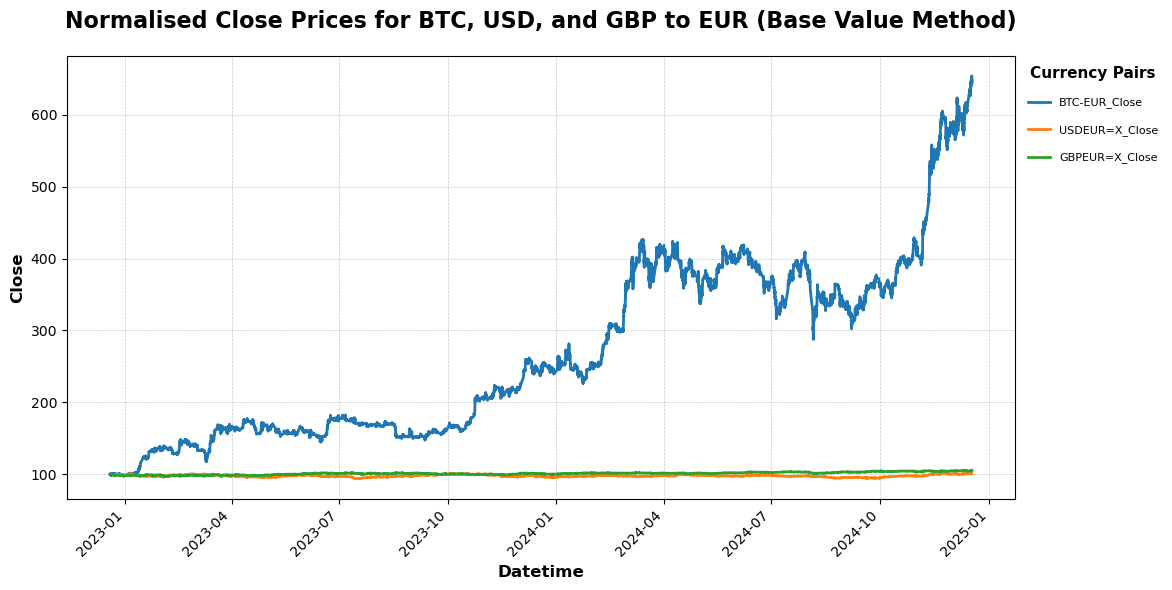

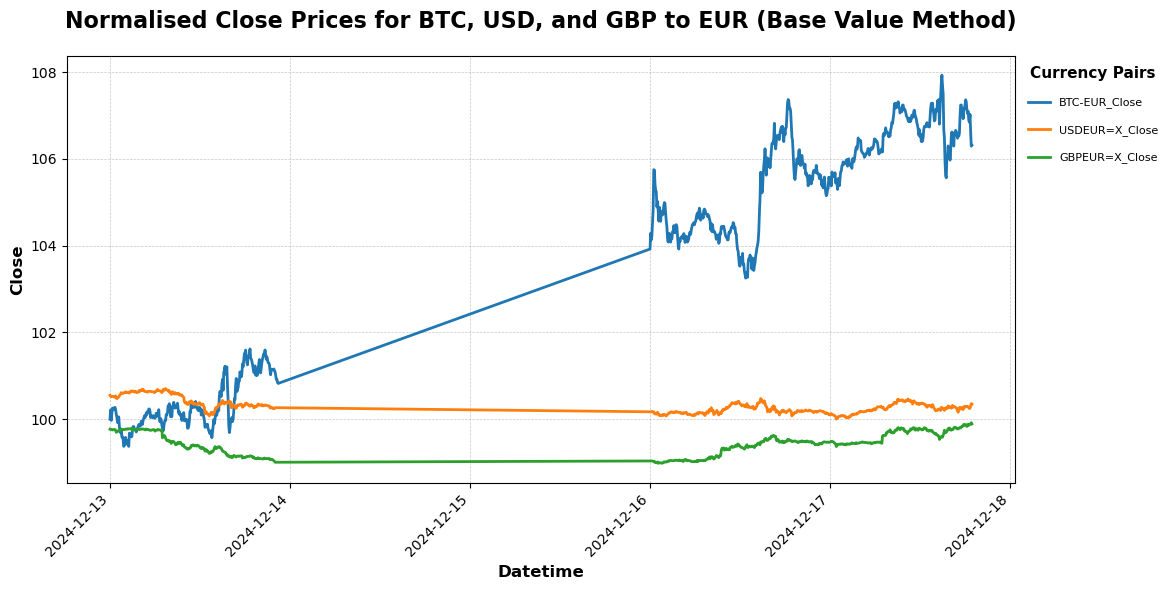

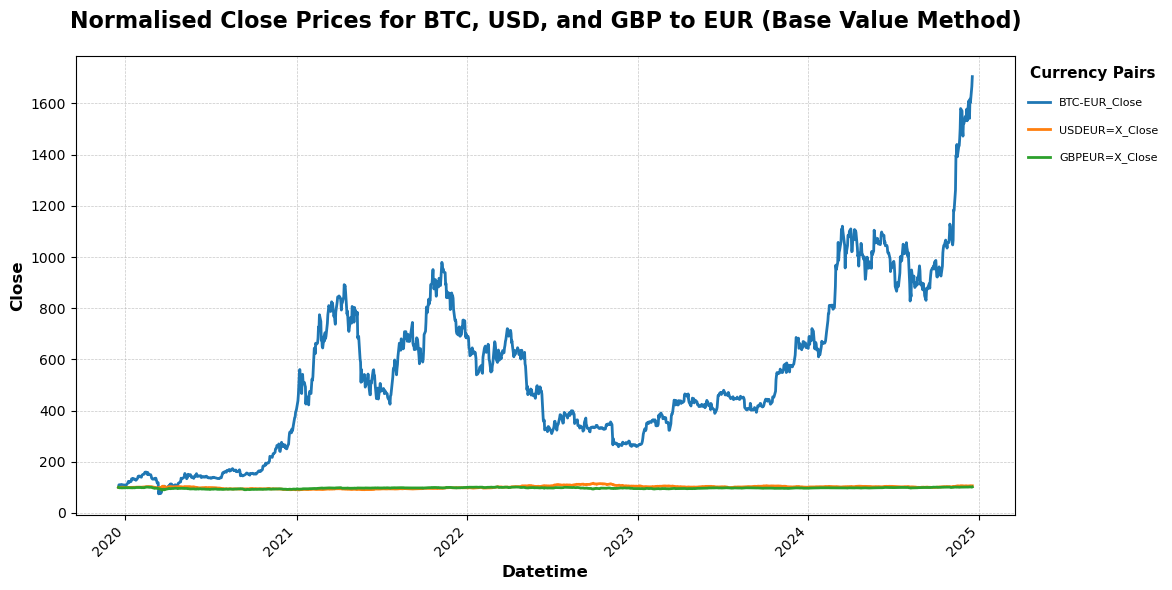

In [40]:

def plotClosePrices(datasets, specificColumns=None, title='Close Prices for Currency Pairs'):
    """
    Universal function to plot 'Close' prices for any list of datasets.
    
    Parameters:
    - datasets: List of dataframes to plot.
    - specific_columns: List of column names to plot. If None, plots all columns with 'Close' in the name.
    - title: Title for the plot (default: 'Close Prices for Currency Pairs').
    """
    # Loop through each dataset in the list
    for df in datasets:
        plt.figure(figsize=(12, 6))
        
        # If specific columns are provided, use them; otherwise, find columns with 'Close' in their names
        if specificColumns:
            columnsToPlot = specificColumns
        else:
            columnsToPlot = [col for col in df.columns if 'Close' in col]

        # Plot each of the selected columns
        for column in columnsToPlot:
            plt.plot(df.index, df[column], label=column, linewidth=2)

        # Labeling and styling the plot
        plt.xlabel('Datetime', fontsize=12, fontweight='bold')
        plt.ylabel('Close', fontsize=12, fontweight='bold')
        plt.title(title, fontsize=16, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        
        # Customize the legend
        plt.legend(loc='upper left', bbox_to_anchor=(1.003, 1), title='Currency Pairs',     
                   frameon=False, fancybox=True, shadow=True, fontsize=8, 
                   title_fontproperties=font_manager.FontProperties(weight='bold', size=11), labelspacing=1.5)
        
        # Adjust layout to fit the plot and legend
        plt.tight_layout()
        plt.subplots_adjust(right=0.85)
        plt.show()

# Example usage:
datasets = [allNormalisedBasedValue2y, allNormalisedBasedValue5d, allNormalisedBasedValue5y]
specificColumns = ['BTC-EUR_Close', 'USDEUR=X_Close', 'GBPEUR=X_Close']  # Define columns you want to plot
plotClosePrices(datasets, specificColumns, title='Normalised Close Prices for BTC, USD, and GBP to EUR (Base Value Method)')


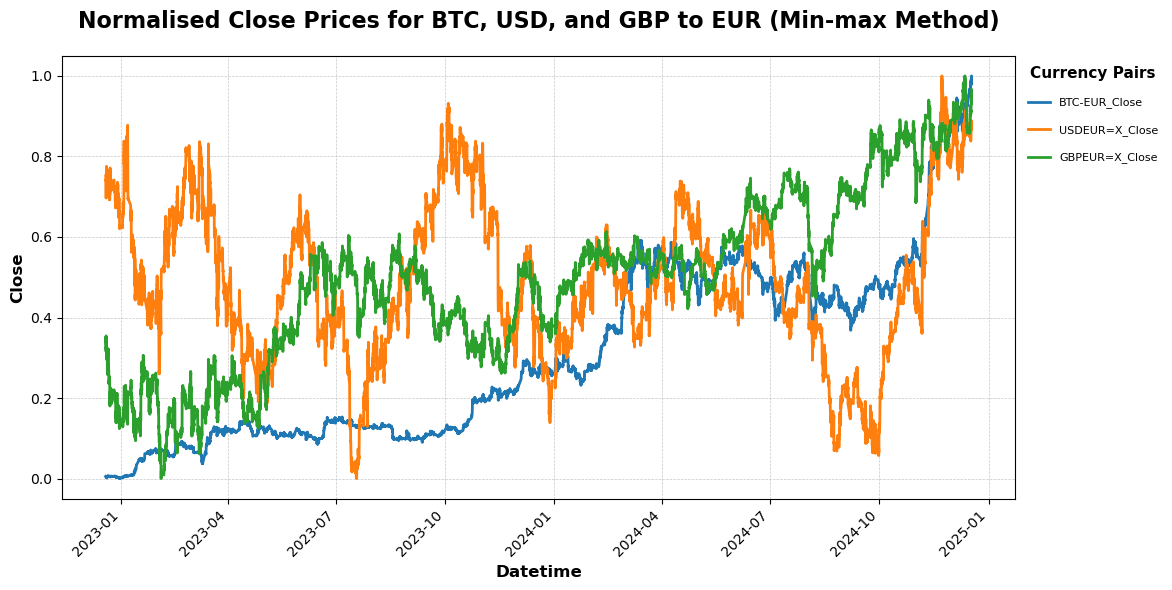

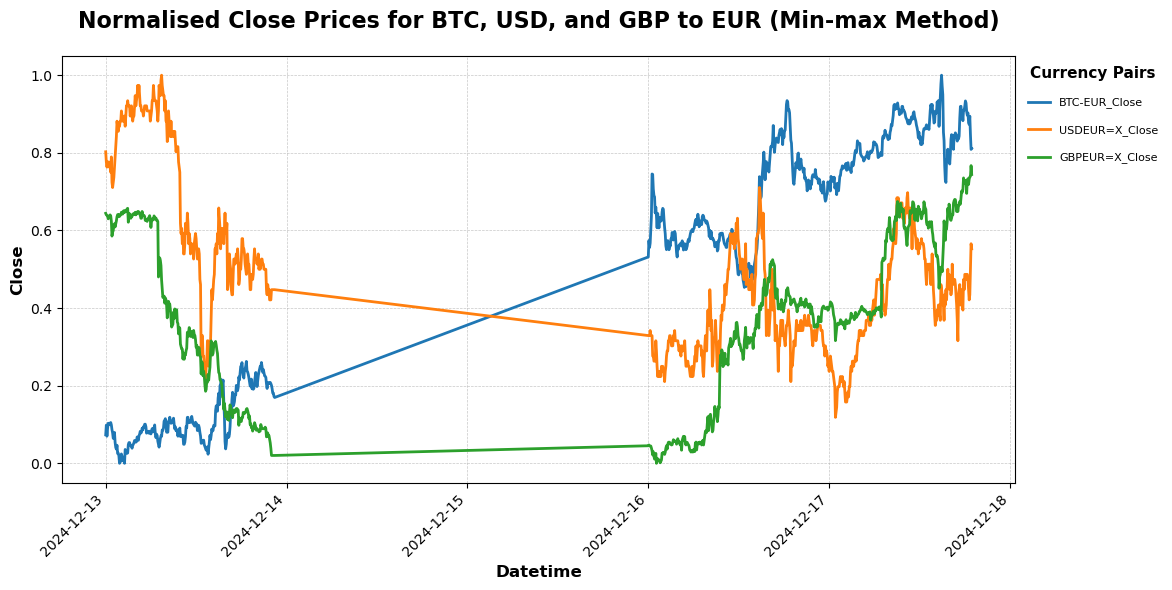

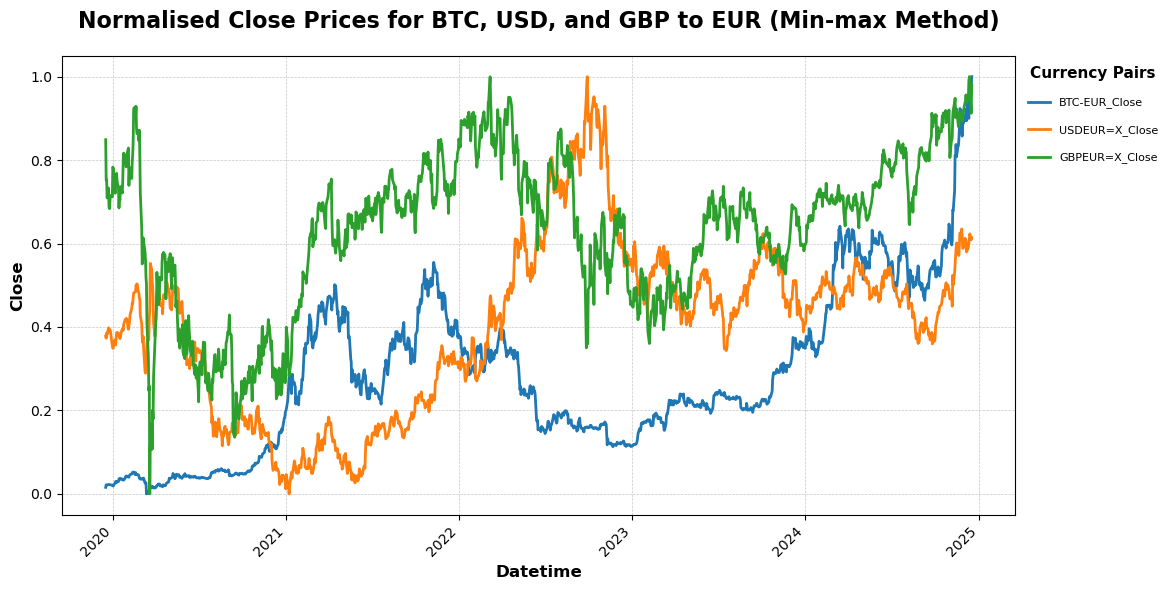

In [41]:
datasets = [allNormalisedMinMax2y, allNormalisedMinMax5d, allNormalisedMinMax5y]
specificColumns = ['BTC-EUR_Close', 'USDEUR=X_Close', 'GBPEUR=X_Close']  # Define columns you want to plot
plotClosePrices(datasets, specificColumns, title='Normalised Close Prices for BTC, USD, and GBP to EUR (Min-max Method)')


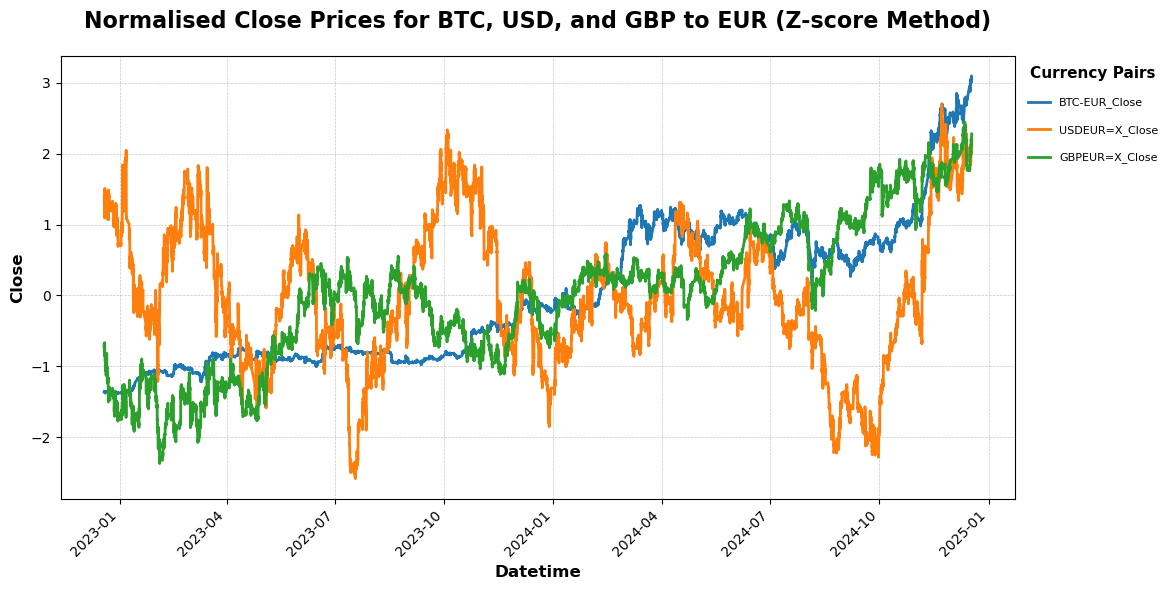

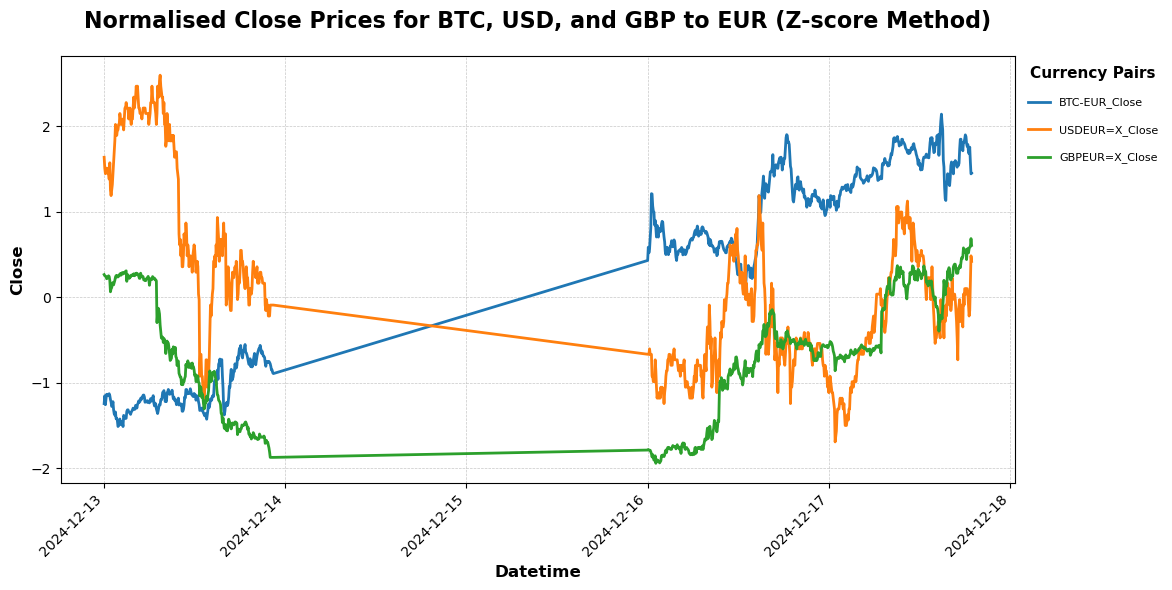

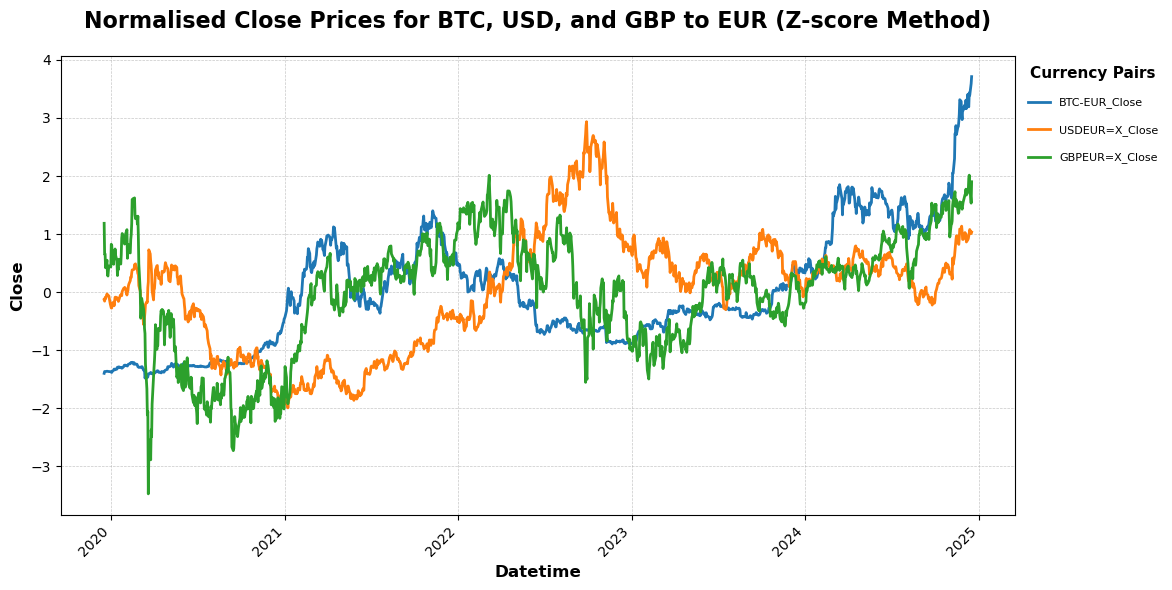

In [42]:
datasets = [allNormalisedZscore2y, allNormalisedZscore5d, allNormalisedZscore5y]
specificColumns = ['BTC-EUR_Close', 'USDEUR=X_Close', 'GBPEUR=X_Close']  # Define columns you want to plot
plotClosePrices(datasets, specificColumns, title='Normalised Close Prices for BTC, USD, and GBP to EUR (Z-score Method)')


In [45]:
allNormalisedBasedValue2y.describe()

,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,USDGBP=X_Open,USDGBP=X_High,USDGBP=X_Low,USDGBP=X_Close,EURUSD=X_Open,EURUSD=X_High,...,BTC-GBP_Low,BTC-GBP_Close,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close
count,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,...,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000
mean,97.839828,97.859037,97.922288,97.953888,96.571774,96.577380,96.659122,96.710340,102.231075,102.144856,...,262.432465,263.305299,274.523504,275.347292,273.905882,274.718147,268.866276,269.701572,268.282635,269.177582
std,1.474370,1.478549,1.471658,1.476568,2.354929,2.363990,2.348028,2.358333,1.540260,1.534998,...,116.810635,117.341770,125.100824,125.602791,124.682484,125.200865,123.865536,124.383371,123.465380,124.025457
min,94.038545,94.061606,94.019722,94.137602,90.570884,90.588077,90.662837,90.687647,98.231754,98.208881,...,98.153703,98.171436,98.144022,98.415064,98.205942,98.177899,97.322214,97.941794,97.393727,97.388854
25%,96.876323,96.898489,96.967450,96.989293,95.314630,95.317745,95.406322,95.449783,101.178501,101.104195,...,160.549103,161.252475,164.597354,164.891710,164.196452,164.629979,161.606472,162.069520,161.396445,161.734423
50%,97.723423,97.745314,97.815718,97.837381,96.213999,96.213597,96.305814,96.351061,102.329621,102.233056,...,240.345188,241.124158,251.230922,251.944639,250.491553,251.484906,244.059862,244.905010,243.656141,244.432080
75%,98.835235,98.846192,98.907859,98.939893,97.997542,98.007728,98.079826,98.137164,103.224406,103.127384,...,360.549785,361.979184,380.221022,381.505903,379.367847,380.531717,370.807663,372.076228,369.771061,371.189204
max,101.800080,102.349951,101.823778,101.929395,102.945611,102.923372,103.053520,103.113052,106.339383,106.360663,...,614.078928,620.124341,647.465130,647.229141,641.754293,647.852745,652.925908,652.897202,648.527922,653.755892


In [ ]:

allNormalisedMinMax2y.describe()

,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,USDGBP=X_Open,USDGBP=X_High,USDGBP=X_Low,USDGBP=X_Close,EURUSD=X_Open,EURUSD=X_High,...,BTC-GBP_Low,BTC-GBP_Close,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close
count,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,...,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000
mean,0.489759,0.458165,0.500069,0.489783,0.484931,0.485542,0.483935,0.484708,0.493279,0.482836,...,0.318416,0.316377,0.321086,0.322390,0.323246,0.321172,0.308753,0.309856,0.310068,0.308769
std,0.189958,0.178389,0.188576,0.189503,0.190301,0.191644,0.189499,0.189799,0.189977,0.188302,...,0.226410,0.224813,0.227737,0.228862,0.229386,0.227773,0.222939,0.224017,0.224021,0.222920
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000513,0.000000,0.000000
25%,0.365621,0.342274,0.377717,0.365986,0.383342,0.383426,0.382827,0.383258,0.363454,0.355176,...,0.120939,0.120856,0.120974,0.121128,0.121407,0.120893,0.115702,0.116008,0.116129,0.115653
50%,0.474762,0.444444,0.486413,0.474830,0.456019,0.456051,0.455421,0.455793,0.505434,0.493656,...,0.275605,0.273880,0.278684,0.279748,0.280169,0.278905,0.264105,0.265197,0.265384,0.264292
75%,0.618008,0.577267,0.626359,0.616327,0.600147,0.601498,0.598594,0.599539,0.615797,0.603365,...,0.508593,0.505424,0.513501,0.515823,0.517271,0.513674,0.492231,0.494235,0.494212,0.492122
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
allNormalisedZscore2y.describe()

,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,USDGBP=X_Open,USDGBP=X_High,USDGBP=X_Low,USDGBP=X_Close,EURUSD=X_Open,EURUSD=X_High,...,BTC-GBP_Low,BTC-GBP_Close,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close
count,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,...,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000,12351.000000
mean,0.001741,0.001744,0.001757,0.001751,-0.001230,-0.001249,-0.001236,-0.001235,-0.001716,-0.001733,...,-0.001961,-0.000983,-0.000851,0.000011,-0.001822,-0.000841,-0.000248,0.000583,-0.001213,-0.000248
std,1.000856,1.000849,1.000820,1.000826,1.001558,1.001546,1.001556,1.001553,1.000873,1.000837,...,0.998507,0.999107,0.999506,1.000035,0.998891,0.999521,0.999235,0.999779,0.998639,0.999276
min,-2.578708,-2.568787,-2.652234,-2.584947,-2.553426,-2.538724,-2.558964,-2.558994,-2.600507,-2.568037,...,-1.406229,-1.407016,-1.410052,-1.408704,-1.409439,-1.410223,-1.384110,-1.380002,-1.383433,-1.384353
25%,-0.652321,-0.648464,-0.647593,-0.652057,-0.535897,-0.534916,-0.535621,-0.536577,-0.685688,-0.680257,...,-0.872868,-0.869912,-0.879117,-0.879424,-0.880757,-0.879713,-0.865522,-0.864551,-0.865753,-0.865920
50%,-0.077279,-0.075237,-0.070717,-0.077218,-0.153393,-0.155373,-0.151941,-0.153816,0.062320,0.055774,...,-0.190765,-0.189845,-0.186949,-0.186318,-0.189406,-0.186320,-0.200363,-0.198729,-0.200402,-0.199623
75%,0.677460,0.669962,0.672007,0.670071,0.605153,0.604743,0.604768,0.604719,0.643758,0.638887,...,0.836754,0.839176,0.843630,0.845234,0.843085,0.843905,0.822123,0.823459,0.819667,0.821662
max,2.690104,3.041701,2.655016,2.696371,2.709580,2.687343,2.726307,2.717913,2.667895,2.747024,...,3.003941,3.037153,2.978804,2.960892,2.945189,2.978020,3.097997,3.080665,3.074367,3.098307
